In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from control.modules.consumers import ConsumersControl, ConsumersParameters
from input_output.alarms import BaseAlarms
from input_output.base import Stamped
from input_output.definitions.simulation import Boundary
from input_output.modules.consumers import (
    ConsumersControlValues,
    ConsumersSensorValues,
    ConsumersSimulationInputs,
    ConsumersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import consumers_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=59)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)

simulation_inputs = ConsumersSimulationInputs(
    consumers_boosting_supply=Boundary(
        temperature=Stamped.stamp(30.0), flow=Stamped.stamp(10.0)
    ),
    consumers_fahrenheit_supply=Boundary(
        temperature=Stamped.stamp(30.0), flow=Stamped.stamp(10.0)
    ),
    consumers_module_supply=Boundary(
        temperature=Stamped.stamp(60.0), flow=Stamped.stamp(10.0)
    ),
)

control = ConsumersControl(
    ConsumersParameters(
        boosting_enabled=True,
        boosting_flow_ratio_setpoint=0.3,
        fahrenheit_enabled=True,
        fahrenheit_flow_ratio_setpoint=0.3,
    )
)

consumers_model = SimulatorModel(
    fmu_path=consumers_path,
    sensor_values_cls=ConsumersSensorValues,
    control_values_cls=ConsumersControlValues,
    simulation_outputs_cls=ConsumersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=BaseAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with consumers_model.executor() as executor:
    simulation = Simulator(consumers_model, executor)

    result = await simulation.run(int(duration.total_seconds()))

/Users/alje/Repos/zero/zero-thrs-control/analysis/analysis_utils.py:345: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(


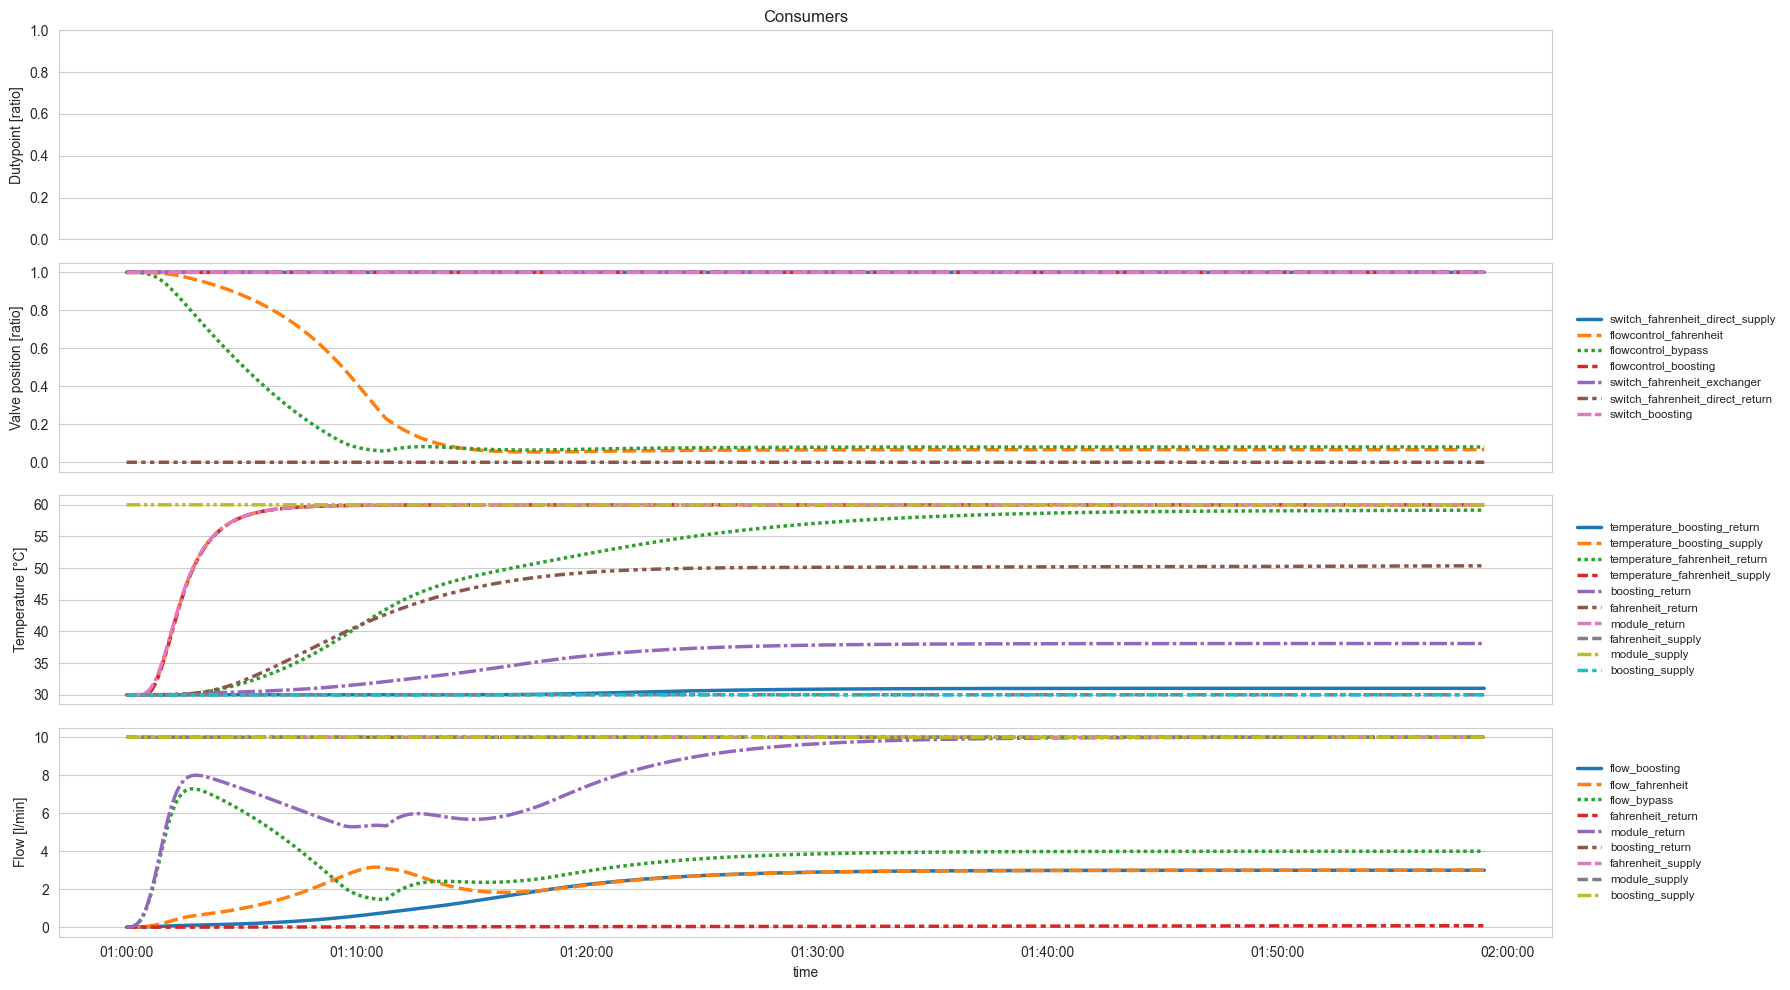

In [3]:
from analysis.analysis_utils import plot_result

plot_result(result, "plots/consumers.png");